<a href="https://colab.research.google.com/github/neosavvy/hodl-coastguard/blob/main/UnsupervisedLearningExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# In case you need it - here are some jpg download commands 
#!rm -rf /content/drive/MyDrive/BoatsForHodl/frames
#!rm -rf /content/drive/MyDrive/BoatsForHodl/frames.zip

# Hope this part helps us maybe create a consistent directory structure 

!wget https://www.dropbox.com/s/w6lk6fw6uhfuez3/frames.zip
!mv /content/frames.zip /content/drive/MyDrive/BoatsForHodl
!unzip -q /content/drive/MyDrive/BoatsForHodl/frames.zip -d /content/drive/MyDrive/BoatsForHodl/

--2022-05-02 22:42:44--  https://www.dropbox.com/s/w6lk6fw6uhfuez3/frames.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w6lk6fw6uhfuez3/frames.zip [following]
--2022-05-02 22:42:44--  https://www.dropbox.com/s/raw/w6lk6fw6uhfuez3/frames.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b9d4854420c6346eb74c6a560.dl.dropboxusercontent.com/cd/0/inline/Bkjtepj7zcsUJYjKsHhZPMHx7nmsSNXqIu5SlegaFZjgxCXOVpapXkaAZd4PGen0LGMFQMdewx-jDTE6Rpa7vs0DeSBcK92LIK2CFozoL9OWsQKqXLH9UbEpKRnXunE2C7qVaGUMp42unlWdEy1HFB8oo7ja74PbmLEZ1RyM7FvF6w/file# [following]
--2022-05-02 22:42:45--  https://uc4b9d4854420c6346eb74c6a560.dl.dropboxusercontent.com/cd/0/inline/Bkjtepj7zcsUJYjKsHhZPMHx7nmsSNXqIu5SlegaFZjgxCXOVpapXkaAZd4PGen0LGMFQMdew

In [ ]:
#path = r"/content/drive/MyDrive/MIT/Deep Learning/Data/Alon"
path = r"/content/drive/MyDrive/BoatsForHodl/frames"
# # change the working directory to the path where the images are located
# os.chdir(path)

# # this list holds all the image filename
# flowers = []


# # creates a ScandirIterator aliased as files

# #with Path(path).glob('**/*.exe') as files:
#   # loops through each file in the directory
# #paths = Path(path).glob('**/*.exe')
#  #   for file in paths:
# for file in Path(path).glob('**/*.jpg'):
#    # if file.name.endswith('.jpg'):
#           # adds only the image files to the flowers list
#       flowers.append(file.name)
            
# print (len(flowers))        

In [ ]:

maybe_boats = glob.glob(f"{path}/**/*.jpg")
# for path in glob.glob(f"{path}/**/*.jpg"):
#   print(path)

In [ ]:
            
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features
   

In [ ]:

data = {}

# lop through each image in the dataset
for maybe_boat in maybe_boats:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(maybe_boat,model)
        data[maybe_boat] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except Exception as e:
        print(f"Something went wrong trying to deal with a maybe_boat {e}")
          

IsADirectoryError: ignored

In [ ]:
data

In [ ]:

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

In [ ]:

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [ ]:


# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:

# cluster feature vectors
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(x)


KMeans(n_clusters=10, random_state=22)

In [ ]:

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:


# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 54 to 30


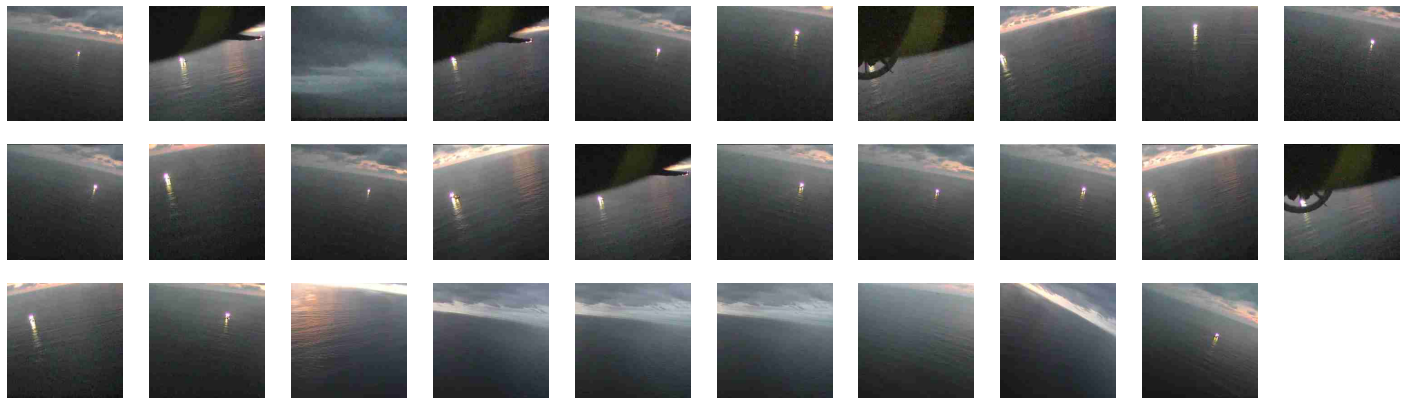

In [ ]:
view_cluster(9)

In [ ]:


 
        
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
        

KeyboardInterrupt: ignored